### Dependancy Imports

In [46]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

# Specific imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

### Import Data

In [47]:
# Assign data to variable
dataset = pd.read_csv('HousingData.csv')
dataset = dataset.head(229)

# Convert the date strings into datetime objects
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Convert Date Features to a number format
dataset['Year'] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month

# Take a small look at the dataframe produced
print(dataset.head())
print(dataset.shape)

        Date  Composite_HPI  Single_Family_HPI  One_Storey_HPI  \
0 2005-01-01          100.0              100.0           100.0   
1 2005-02-01          101.0              101.0           101.2   
2 2005-03-01          102.1              102.1           102.4   
3 2005-04-01          103.1              103.2           103.8   
4 2005-05-01          103.8              103.8           104.6   

   Two_Storey_HPI  Townhouse_HPI  Apartment_HPI  Composite_Benchmark  \
0           100.0          100.0          100.0             237700.0   
1           100.9          100.9          101.3             240100.0   
2           101.9          101.7          102.3             242600.0   
3           102.9          102.5          103.1             245100.0   
4           103.4          103.2          104.1             246700.0   

   Single_Family_Benchmark  One_Storey_Benchmark  Two_Storey_Benchmark  \
0                 257600.0              205000.0              300000.0   
1                 2601

### Split data in to features

In [48]:
# Split data into X and y sets
X = dataset[[
    'Single_Family_Benchmark',
    'One_Storey_Benchmark',
    'Two_Storey_Benchmark',
    'Townhouse_Benchmark',
    'Apartment_Benchmark'
    ]]

y = dataset['Composite_Benchmark']

### Split the dataset

In [49]:
# Set up your sets into train and test variables
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 0
    )

# Show the user a sample of the dataset for reference
print(f"X-train sample: {X_train.head()}")
print(f"y-train sample: {y_train.head()}")

X-train sample:      Single_Family_Benchmark  One_Storey_Benchmark  Two_Storey_Benchmark  \
33                  343000.0              284700.0              388500.0   
71                  358500.0              283400.0              413900.0   
154                 594500.0              442100.0              703900.0   
205                 943800.0              722200.0             1099800.0   
106                 417300.0              322400.0              486400.0   

     Townhouse_Benchmark  Apartment_Benchmark  
33              277200.0             239700.0  
71              288800.0             251900.0  
154             466200.0             402500.0  
205             754200.0             567500.0  
106             312300.0             266400.0  
y-train sample: 33     318700.0
71     332600.0
154    544400.0
205    845400.0
106    380900.0
Name: Composite_Benchmark, dtype: float64


### Feature Scaling

In [50]:
# Create an instance of the scaler
scaler = RobustScaler()

# Initialize empty dataframe for new data
X_train_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()

# Initialize a loop to iterate the train columns
for col in X_train.columns:
  # Skip scaling the year and month but append them still
  # if col in ['Year', 'Month']:
  #   X_train_scaled[col] = X_train[[col]]
  #   X_test_scaled[col] = X_test[[col]]
  # else:
  # Fit/Transformed column data
  col_scaled = scaler.fit_transform(X_train[[col]])

  # Append scaled data to empty dataframe
  X_train_scaled[col] = col_scaled.flatten()

  # Transform test column data
  col_scaled_test = scaler.transform(X_test[[col]])

  # Append scaled data to empty dataframe
  X_test_scaled[col] = col_scaled_test.flatten()

print(X_train_scaled)
print(X_test_scaled)

     Single_Family_Benchmark  One_Storey_Benchmark  Two_Storey_Benchmark  \
0                  -0.355936             -0.291010             -0.375494   
1                  -0.292812             -0.299042             -0.291831   
2                   0.668296              0.681495              0.663373   
3                   2.090817              2.412110              1.967391   
4                  -0.053350             -0.058078             -0.053030   
..                       ...                   ...                   ...   
178                -0.285074             -0.271239             -0.290843   
179                 1.002647              1.152302              0.949605   
180                 0.042354              0.038307              0.044137   
181                -0.448788             -0.416435             -0.458169   
182                 0.559967              0.644424              0.537220   

     Townhouse_Benchmark  Apartment_Benchmark  
0              -0.211635            -0.

### Setup Basic Model

In [51]:
# Plant the seeds to grow a basic forest
forest_model = RandomForestRegressor(random_state = 0)

### Hyper Parameters

In [52]:
# Setup parameters
param_dist = {'n_estimators': [
    50,
    100,
    150,
    200,
    250,
    300,
    350,
    400,
    450,
    500,
    550,
    600,
    650,
    700,
    750
    ]}

# Initialize the random search
random_search = RandomizedSearchCV(
    estimator = forest_model,
    param_distributions = param_dist,
    n_iter = 15,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    random_state = 0
)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Store the best selection for later
selected_params = random_search.best_params_

# Show the user the best parameter
print(f"Selected Param: {selected_params}")

Selected Param: {'n_estimators': 50}


### Final Model Set up

In [53]:
# Re-Initialize Random Forest using the selected Params
final_forest = RandomForestRegressor(
    n_estimators = selected_params['n_estimators'],
    random_state = 0
)

# Fit data to the new model
final_forest.fit(X_train_scaled, y_train)

# Make prediction to get a score to check
score_predict = final_forest.predict(X_test_scaled)

### Scoring

In [54]:
# Pass in your y test data and check it against your y predicted data
mse = mean_squared_error(y_test, score_predict)

# Calculate R-squared
r_squared = r2_score(y_test, score_predict)

# Share with the world!
print(f"Mean Squared Error: {mse}")
print(f"R-Squared Error: {r_squared}")

Mean Squared Error: 18697681.04347826
R-Squared Error: 0.9993086327577407


### Create Future Data

In [64]:
# Create a dataset for future dates
future_dates = pd.date_range(start='2024-01-01', periods=120, freq='M')
future_data = pd.DataFrame({'Date': future_dates})

# Create future dataset with date features
future_data['Year'] = future_data['Date'].dt.year
future_data['Month'] = future_data['Date'].dt.month

# Add the old data to the new set
future_data['Composite_HPI'] = dataset['Composite_HPI']
future_data['Single_Family_Benchmark'] = dataset['Single_Family_Benchmark']
future_data['One_Storey_Benchmark'] = dataset['One_Storey_Benchmark']
future_data['Two_Storey_Benchmark'] = dataset['Two_Storey_Benchmark']
future_data['Townhouse_Benchmark'] = dataset['Townhouse_Benchmark']
future_data['Apartment_Benchmark'] = dataset['Apartment_Benchmark']

# Grab features for prediction
features_for_prediction = future_data[[
    'Single_Family_Benchmark',
    'One_Storey_Benchmark',
    'Two_Storey_Benchmark',
    'Townhouse_Benchmark',
    'Apartment_Benchmark'
    ]]

scaled_features_for_prediction = scaler.transform(features_for_prediction)

# Print a sample of the normalized future dataset
print(f"Normalized Future Data:\n {features_for_prediction.head()}")
print(f"Normalized Future Data:\n {scaled_features_for_prediction}")

Normalized Future Data:
    Single_Family_Benchmark  One_Storey_Benchmark  Two_Storey_Benchmark  \
0                 257600.0              205000.0              300000.0   
1                 260100.0              207400.0              302700.0   
2                 263000.0              210000.0              305700.0   
3                 265800.0              212700.0              308600.0   
4                 267500.0              214500.0              310100.0   

   Townhouse_Benchmark  Apartment_Benchmark  
0             199600.0             172400.0  
1             201400.0             174600.0  
2             202900.0             176400.0  
3             204500.0             177800.0  
4             205900.0             179500.0  
Normalized Future Data:
 [[-1.1504914  -1.69046378 -0.98140546 -2.01420959 -1.9075    ]
 [-1.11977887 -1.64043773 -0.9553248  -1.97158082 -1.8525    ]
 [-1.08415233 -1.58624283 -0.92634629 -1.93605684 -1.8075    ]
 [-1.0497543  -1.52996352 -0.89833374 -1

### Predict Outcome

In [65]:
# Predict future prices
future_predictions = final_forest.predict(scaled_features_for_prediction)

print(future_predictions)

# # Add predicted prices to future_data
future_data['Composite_Benchmark_Predicted'] = future_predictions[0:120]

[239284. 239284. 239284. 239284. 239284. 239284. 239284. 239284. 239284.
 239284. 239284. 239284. 239284. 239284. 240598. 246848. 249406. 256688.
 258602. 263254. 268186. 265316. 265316. 264648. 275362. 287488. 295502.
 304724. 329516. 338616. 344088. 346490. 349328. 348216. 348194. 347894.
 352106. 369582. 382854. 390814. 386836. 373954. 367486. 356086. 344684.
 328688. 307996. 290656. 287082. 284910. 283580. 288538. 295642. 303234.
 322270. 336006. 346800. 350286. 358844. 375244. 390944. 408358. 423670.
 435268. 435898. 431860. 425770. 416810. 414628. 413596. 407108. 408038.
 417652. 436596. 458454. 467496. 483412. 488856. 491868. 495014. 495014.
 494630. 494630. 491246. 504932. 515306. 530738. 536118. 550760. 534298.
 531454. 531102. 529038. 516496. 510516. 507652. 510694. 527198. 532582.
 553760. 561342. 564114. 564428. 564208. 566692. 564406. 565176. 565176.
 573652. 588682. 591116. 601098. 603644. 610746. 610746. 609316. 612210.
 614206. 612776. 612530.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Graphs

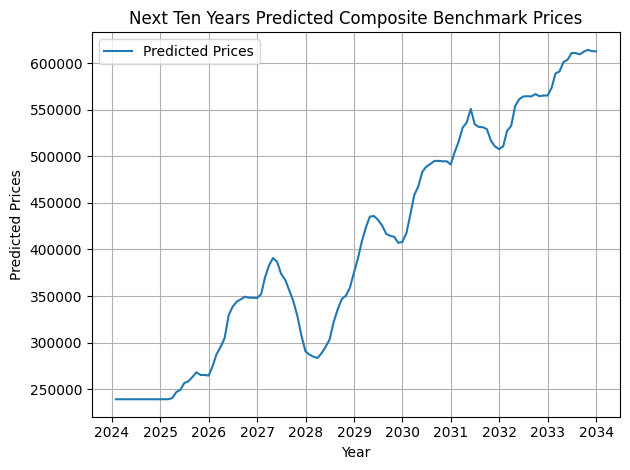

In [66]:
# Plot the predicted Composite Benchmark prices over time
plt.plot(
    future_data['Date'],
    future_data['Composite_Benchmark_Predicted'],
    label='Predicted Prices'
    )

# Set up the axis
plt.xlabel('Year')
plt.ylabel('Predicted Prices')
plt.title('Next Ten Years Predicted Composite Benchmark Prices')

# Make the graph look nice
plt.tight_layout()
plt.legend()
plt.grid(True)

# Save the graph for a rainy day
plt.savefig('PredictionGraph.svg', format='svg', bbox_inches='tight')

# Display the graph to the end user
plt.show()